In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import nfl_data_py as nfl
from explore import summarize_df, check_missing_values
from transform import filter_to_plays, aggregate_df, add_calc_stats
from model import linreg_evaluate, rf_model_evaluate, logreg_model_evaluate
from predict import predict_winner, predict_week
from optimize import optimize_year, optimize_alpha

In [2]:
# find best range of years to train on
#optimize_year((2020, 2023), 2024, 'logreg')

In [3]:
# range of years to pull from (2003-2023)
years = list(range(2013,2024))

# columns to pull from database
columns =   ['play_id', 'game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type',
             'side_of_field', 'yardline_100', 'game_date', 'game_seconds_remaining', 'down', 'ydsnet', 'desc',
             'play_type', 'yards_gained', 'pass_length', 'yards_after_catch', 'field_goal_result', 
             'kick_distance', 'extra_point_result', 'two_point_conv_result', 'total_home_score', 
             'total_away_score', 'ep', 'epa', 'total_home_epa', 'total_away_epa', 'total_home_rush_epa', 
             'total_away_rush_epa', 'total_home_pass_epa', 'total_away_pass_epa', 'wp', 'def_wp', 'home_wp', 
             'away_wp', 'wpa', 'total_home_rush_wpa', 'total_away_rush_wpa', 'total_home_pass_wpa', 
             'total_away_pass_wpa', 'punt_blocked', 'first_down_rush', 'first_down_pass', 
             'first_down_penalty', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 
             'fourth_down_failed', 'incomplete_pass', 'touchback', 'interception', 'fumble_forced', 
             'fumble_not_forced', 'fumble_out_of_bounds', 'safety', 'penalty', 'fumble_lost', 'rush_attempt', 
             'pass_attempt', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'return_touchdown', 
             'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt', 
             'punt_attempt', 'fumble', 'complete_pass', 'passing_yards', 'receiving_yards', 'rushing_yards', 
             'return_yards', 'penalty_team', 'penalty_yards', 'penalty_type', 'season', 'series_result', 
             'weather', 'play_type_nfl', 'special_teams_play', 'drive_first_downs', 
             'drive_inside20', 'drive_ended_with_score', 'away_score', 'home_score', 'location', 
             'result', 'total', 'spread_line', 'total_line', 'surface', 'temp', 'wind', 'pass', 
             'rush', 'first_down', 'special', 'play', 'qb_epa']

# create df with combined data
df = nfl.import_pbp_data(years, columns, downcast=True)

2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [4]:
# display first n rows, number of rows, number of columns, number of duplicates
summarize_df(df, display_rows=10)


First 10 rows:
   play_id          game_id home_team away_team season_type  week posteam  \
0      1.0  2013_01_ARI_STL        LA       ARI         REG     1    None   
1     35.0  2013_01_ARI_STL        LA       ARI         REG     1      LA   
2     57.0  2013_01_ARI_STL        LA       ARI         REG     1      LA   
3     86.0  2013_01_ARI_STL        LA       ARI         REG     1      LA   
4    107.0  2013_01_ARI_STL        LA       ARI         REG     1      LA   
5    136.0  2013_01_ARI_STL        LA       ARI         REG     1      LA   
6    171.0  2013_01_ARI_STL        LA       ARI         REG     1      LA   
7    192.0  2013_01_ARI_STL        LA       ARI         REG     1      LA   
8    215.0  2013_01_ARI_STL        LA       ARI         REG     1      LA   
9    237.0  2013_01_ARI_STL        LA       ARI         REG     1      LA   

  posteam_type side_of_field  yardline_100  ... offense_players  \
0         None          None           NaN  ...             NaN   
1 

In [5]:
# display how many nans are in each column (check_missing_values returns df of missing values)
check_missing_values(df, display_rows=500)

                    Column  NA_Count
0    two_point_conv_result    528638
1        field_goal_result    518375
2       extra_point_result    515841
3             penalty_team    492571
4             penalty_type    492571
..                     ...       ...
120                surface         0
121                home_wp         0
122                   pass         0
123                   rush         0
124                play_id         0

[125 rows x 2 columns]


,Column,NA_Count
0,two_point_conv_result,528638
1,field_goal_result,518375
2,extra_point_result,515841
3,penalty_team,492571
4,penalty_type,492571
...,...,...
120,surface,0
121,home_wp,0
122,pass,0
123,rush,0


In [6]:
# filter df to only include plays (gets rid of timeouts, penalties, start of game, etc.)
filtered_df = filter_to_plays(df)

# use one hot encoding on the listed columns
columns_to_encode = ['field_goal_result',
                     'extra_point_result',
                     'two_point_conv_result']
encoded_df = pd.get_dummies(filtered_df, columns=columns_to_encode, drop_first=True)

# columns to group by in aggregate_df
group_by = ['game_id', 'posteam', 'home_team', 'away_team']

# dict of columns to be included in aggregated_df and the corresponding functions to be applied
column_functions = {'yards_gained': 'sum',
                    'receiving_yards': 'sum',
                    'rushing_yards': 'sum',
                    'return_yards': 'sum',
                    'incomplete_pass': 'sum',
                    'complete_pass': 'sum',
                    'interception': 'sum',
                    'pass_attempt': 'sum',
                    'rush_attempt': 'sum',
                    'touchdown': 'sum',
                    'pass_touchdown': 'sum',
                    'rush_touchdown': 'sum',
                    'return_touchdown': 'sum',
                    'first_down': 'sum',
                    'play': 'sum',
                    'sack': 'sum',
                    'fumble': 'sum',
                    'fumble_lost': 'sum',
                    'field_goal_result_made': 'sum',
                    'field_goal_result_missed': 'sum',
                    'extra_point_result_good': 'sum',
                    'extra_point_result_failed': 'sum',
                    'safety': 'sum',
                    'total_home_epa': 'max',
                    'total_away_epa': 'max',
                    'total_home_score': 'max',
                    'total_away_score': 'max',
                    'total': 'max'}

# turn column_functions into a df
df_column_functions = pd.DataFrame(list(column_functions.items()), columns=['Column', 'Function'])

# create aggregated_df
aggregated_df = aggregate_df(encoded_df, group_by, df_column_functions)

# add calculated stats columns (win, season, yards_per_play_offense, points_per_play_offense, 
#                               first_down_rate_offense, turnovers_lost, yards_per_play_allowed, 
#                               points_per_play_allowed, first_down_rate_allowed, turnovers_gained,
#                               turnover_differential, fg percentage, xp percentage)
transformed_df = add_calc_stats(aggregated_df, encoded_df)

c:\Users\alrec\Desktop\DAT Capstone\DAT-Capstone\transform.py:69: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  aggregated = df.groupby(group_by_list).agg(column_func_df.set_index('Column')['Function']).reset_index()


In [7]:
# select features to be used in models
features = ['yards_per_play_offense', 'first_down_rate_offense', 'yards_per_play_allowed', 
            'first_down_rate_allowed', 'turnover_differential', 'interception', 'sack']
# select target_variable
target_variable = 'win'

# create X (df of feature columns) and y (series for the target variable)
X = transformed_df[features]
y = transformed_df[target_variable]
    
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# create and evaluate linear regression model
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
linreg_evaluate(linreg_model, features_test = X_test, target_test = y_test)

Mean Squared Error: 0.13
Root Mean Squared Error: 0.36
R² Score: 0.49
                   Feature  Coefficient
3  first_down_rate_allowed    -2.325345
1  first_down_rate_offense     2.133517
4    turnover_differential     0.103824
2   yards_per_play_allowed    -0.064966
0   yards_per_play_offense     0.057168
6                     sack    -0.030280
5             interception    -0.025021


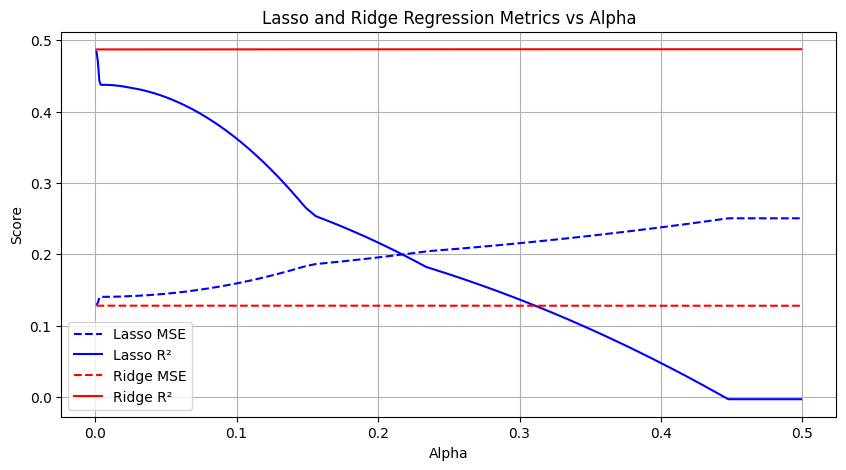

In [9]:
# plot the relationship between alpha and r^2/mse for ridge and lasso models to determine alpha
#optimize_alpha(mode='both', features_train=X_train, target_train=y_train, features_test=X_test, target_test=y_test)

In [10]:
# create and evaluate ridge regression model
ridge_model = Ridge(alpha=.05)
ridge_model.fit(X_train, y_train)
linreg_evaluate(ridge_model, features_test = X_test, target_test = y_test)

Mean Squared Error: 0.13
Root Mean Squared Error: 0.36
R² Score: 0.49
                   Feature  Coefficient
3  first_down_rate_allowed    -2.308089
1  first_down_rate_offense     2.117422
4    turnover_differential     0.103839
2   yards_per_play_allowed    -0.065506
0   yards_per_play_offense     0.057652
6                     sack    -0.030296
5             interception    -0.025044


In [11]:
# create and evaluate lasso regression model
lasso_model = Lasso(alpha=.01)
lasso_model.fit(X_train, y_train)
linreg_evaluate(lasso_model, features_test = X_test, target_test = y_test)

Mean Squared Error: 0.14
Root Mean Squared Error: 0.37
R² Score: 0.44
                   Feature  Coefficient
2   yards_per_play_allowed    -0.128900
0   yards_per_play_offense     0.113974
4    turnover_differential     0.107721
6                     sack    -0.031506
5             interception    -0.015978
1  first_down_rate_offense     0.000000
3  first_down_rate_allowed    -0.000000


In [12]:
# create and evaluate random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_model_evaluate(rf_model, features_test=X_test, target_test=y_test, tree_plot=False, feature_importance=False)

Accuracy: 0.8254
Confusion Matrix:
[[504 112]
 [ 97 484]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       616
           1       0.81      0.83      0.82       581

    accuracy                           0.83      1197
   macro avg       0.83      0.83      0.83      1197
weighted avg       0.83      0.83      0.83      1197



Accuracy: 0.8338
Confusion Matrix:
[[500 116]
 [ 83 498]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       616
           1       0.81      0.86      0.83       581

    accuracy                           0.83      1197
   macro avg       0.83      0.83      0.83      1197
weighted avg       0.84      0.83      0.83      1197

Accuracy: 0.8338
Confusion Matrix:
[[500 116]
 [ 83 498]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       616
           1       0.81      0.86      0.83       581

    accuracy                           0.83      1197
   macro avg       0.83      0.83      0.83      1197
weighted avg       0.84      0.83      0.83      1197


Feature Importance:
                   Feature  Coefficient  Importance
3  first_down_rate_allowed    -8.328264    8.328264
1  first_down_rate_offense     7.549761    7.549761
2   yar

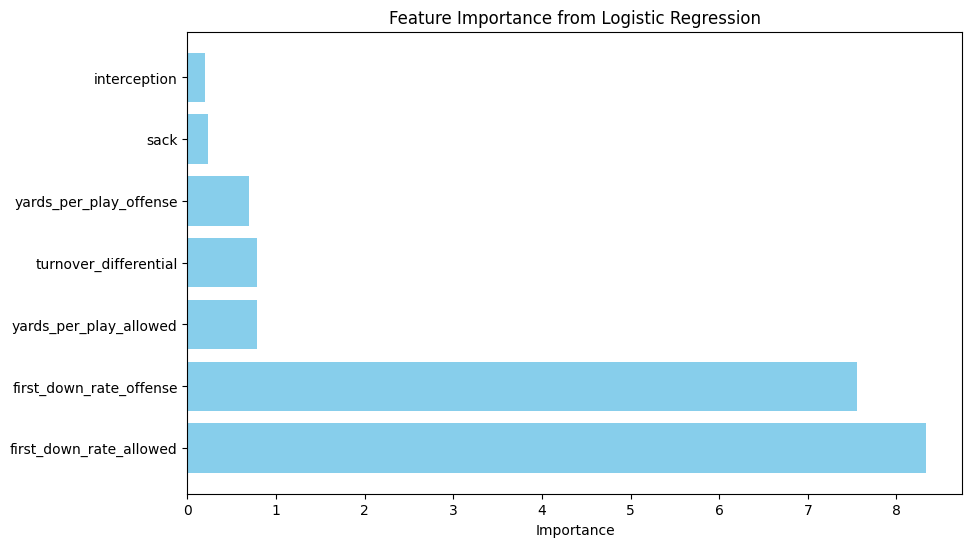

      Actual  Predicted  Probability
1073       0          0     0.023293
5468       0          1     0.607733
5306       1          1     0.855116
1321       0          1     0.790532
4844       0          1     0.779330
1720       1          1     0.786702
2157       0          0     0.061318
5012       0          0     0.200304
4379       0          0     0.259037
3148       1          1     0.925929


In [13]:
# create and evaluate logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
logreg_model_evaluate(logreg_model, X_test, y_test)
print(logreg_model_evaluate(logreg_model, X_test, y_test, feature_importance=True).head(10))

In [14]:
# load the current season's play by play data
df_current = nfl.import_pbp_data([2024], columns, downcast=True)

# create filtered_df_current
filtered_df_current = filter_to_plays(df_current)

# create encoded_df_current
encoded_df_current = pd.get_dummies(filtered_df_current, columns=columns_to_encode, drop_first=True)

# create aggregated_df_current
aggregated_df_current = aggregate_df(encoded_df_current, group_by, df_column_functions)

# create transformed_df_current
transformed_df_current = add_calc_stats(aggregated_df_current, encoded_df_current)

2024 done.
Downcasting floats.


c:\Users\alrec\Desktop\DAT Capstone\DAT-Capstone\transform.py:69: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  aggregated = df.groupby(group_by_list).agg(column_func_df.set_index('Column')['Function']).reset_index()


In [15]:
# column functions parameter for aggregate_df the second time
column_functions = {'turnover_differential': 'mean',
                    'first_down_rate_allowed': 'mean',
                    'first_down_rate_offense': 'mean',
                    'yards_per_play_allowed': 'mean',
                    'yards_per_play_offense': 'mean',
                    'interception': 'mean',
                    'sack': 'mean'}
df_column_functions = pd.DataFrame(list(column_functions.items()), columns=['Column', 'Function'])

# aggregate season_team_df
season_team_df_2024 = aggregate_df(transformed_df_current, ['posteam'], df_column_functions)

c:\Users\alrec\Desktop\DAT Capstone\DAT-Capstone\transform.py:69: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  aggregated = df.groupby(group_by_list).agg(column_func_df.set_index('Column')['Function']).reset_index()


In [16]:
# identify features from season_team_df_current
features = season_team_df_2024[['yards_per_play_offense', 'first_down_rate_offense', 'yards_per_play_allowed', 
                                'first_down_rate_allowed', 'turnover_differential', 'interception',
                                'sack']]

# scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# create scaled_df_current
scaled_df_2024 = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df_2024['posteam'] = season_team_df_2024['posteam']
scaled_df_2024 = scaled_df_2024.reset_index(drop=True)

In [17]:
# predict the winner of an nfl game
home = 'BUF'
away = 'NYJ'
predicted_winner, winning_probability = predict_winner(logreg_model, scaled_df_2024, home, away)
print(f"Predicted Winner: {predicted_winner}, Probability: {winning_probability:.2f}%")

Predicted Winner: BUF, Probability: 99.92%


In [18]:
# predict a week of nfl games
week_7_schedule = [
    ('NO', 'DEN'),
    ('JAX', 'NE'),
    ('WAS', 'CAR'),
    ('PIT', 'NYJ'),
    ('TB', 'BAL'),
    ('BUF', 'TEN'),
    ('HOU', 'GB'),
    ('NYG', 'PHI'),
    ('MIN', 'DET'),
    ('ATL', 'SEA'),
    ('CLE', 'CIN'),
    ('IND', 'MIA'),
    ('LV', 'LA'),
    ('SF', 'KC'),
    ('ARI', 'LAC'),
]

predictions_df = predict_week(logreg_model, scaled_df_2024, week_7_schedule)
print(predictions_df)

   Home Away Predicted Winner  Winning Probability (%)
0    NO  DEN               NO                  9994.58
1   JAX   NE              JAX                     0.06
2   WAS  CAR              WAS                   618.79
3   PIT  NYJ              NYJ                  9953.90
4    TB  BAL              BAL                 10000.00
5   BUF  TEN              TEN                  9998.73
6   HOU   GB              HOU                  9998.87
7   NYG  PHI              NYG                  9915.15
8   MIN  DET              MIN                 10000.00
9   ATL  SEA              SEA                  9819.27
10  CLE  CIN              CIN                  1436.92
11  IND  MIA              IND                  9913.09
12   LV   LA               LV                  8445.58
13   SF   KC               KC                  9999.96
14  PIT  NYJ              NYJ                  9953.90
15  ARI  LAC              LAC                  9966.52


In [19]:
# download any models or datasets
i = input("Would you like to save any files from the project? (y/n)")
if i in {'Y','y', 'ex'}:
    i = input("Would you like to save the models to a folder? (y/n)")
    if i in {'Y','y', 'ex'}:
        if i == 'ex':
            filepath = r'C:/Users/alrec/Desktop/DAT Capstone/models'
        else:
            filepath = input("Please enter the filepath for the folder to save to: ")
        os.makedirs(filepath, exist_ok=True)
        joblib.dump(linreg_model, f'{filepath}\linreg_model.pkl')
        joblib.dump(ridge_model, f'{filepath}/ridge_model.pkl')
        joblib.dump(lasso_model, f'{filepath}\lasso_model.pkl')
        joblib.dump(rf_model, f'{filepath}/rf_model.pkl')
        joblib.dump(logreg_model, f'{filepath}/logreg_model.pkl')
        print('models saved')
    
    i = input("Would you like to save the data to a folder? (y/n)").strip()

    if i in {'Y', 'y', 'ex'}:
        if i == 'ex':
            filepath = r'C:/Users/alrec/Desktop/DAT Capstone/dataframes'
        else:
            filepath = input("Please enter the filepath for the folder to save to: ").strip()
        
        os.makedirs(filepath, exist_ok=True)
        
        df.to_csv(os.path.join(filepath, 'df.csv'), index=False)
        filtered_df.to_csv(os.path.join(filepath, 'filtered_df.csv'), index=False)
        encoded_df.to_csv(os.path.join(filepath, 'encoded_df.csv'), index=False)
        aggregated_df.to_csv(os.path.join(filepath, 'aggregated_df.csv'), index=False)
        transformed_df.to_csv(os.path.join(filepath, 'transformed_df.csv'), index=False)

        df_current.to_csv(os.path.join(filepath, 'df_current.csv'), index=False)
        filtered_df_current.to_csv(os.path.join(filepath, 'filtered_df_current.csv'), index=False)
        encoded_df_current.to_csv(os.path.join(filepath, 'encoded_df_current.csv'), index=False)
        aggregated_df_current.to_csv(os.path.join(filepath, 'aggregated_df_current.csv'), index=False)
        transformed_df_current.to_csv(os.path.join(filepath, 'transformed_df_current.csv'), index=False)

        season_team_df_2024.to_csv(os.path.join(filepath, 'season_team_df_2024.csv'), index=False)
        scaled_df_2024.to_csv(os.path.join(filepath, 'scaled_df_2024.csv'), index=False)

        print('Dataframes saved successfully')
